# Text Analysis with 10-K Business Descriptions from Edgar
- part-of-speech tagging, lemmatizing, multilevel community detection
- spacy, nltk, sklearn, igraph
- Hoberg and Phillips (2016), SEC Edgar, Wharton Research Data Services

Terence Lim
License: MIT

In [1]:
import re
import os
import time
import gzip, json
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
import seaborn as sns
import igraph  # pip3 install cairocffi
from igraph import Graph
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from collections import Counter
from finds.database import SQL, MongoDB, Redis
from finds.structured import CRSP, PSTAT
from finds.busday import BusDay, int2date
from finds.unstructured import Unstructured
from finds.edgar import EdgarClone, Edgar
from finds.graph import igraph_info, igraph_community
from finds.sectors import Sectoring
from settings import settings
ECHO = False
sql = SQL(**settings['sql'])
user = SQL(**settings['user'])
bd = BusDay(sql)
rdb = Redis(**settings['redis'])
crsp = CRSP(sql, bd, rdb)
mongodb = MongoDB(**settings['mongodb'])
wordlists = Unstructured(mongodb, 'WordLists')
ed = EdgarClone(settings['10X'], zipped=True, echo=ECHO)
imgdir = os.path.join(settings['images'], 'edgar')
item, form = 'bus10K', '10-K'

# Retrieve business description (10-K item 1) from Edgar


In [2]:
from nltk.tokenize import RegexpTokenizer
ticker = 'AAPL'
cik = Edgar.fetch_tickers()[ticker.lower()]                 # lookup aapl's cik
stop_words = [w for c in ['genericlong', 'DatesandNumbers'] # LM stop word lists
              for w in wordlists['lm', c.lower()]] # if "'" not in w]
top_words = {}
for year in [2003, 2020]:
    files = Edgar.fetch_index(year=year, quarter=4)  # 
    r = files[files['cik'].eq(cik) & files['form'].isin(Edgar.forms_['10-K'])]
    htmls = Edgar.extract_filenames(Edgar.fetch_detail(r.iloc[0]['pathname']))
    filing = Edgar.fetch_filing(Edgar.from_path(r.iloc[0]['pathname'],htmls[0]))
    text = Edgar.extract_item(filing, 'bus10K')
    print(ticker, year, 'business description:')
    print(text[:500])
    words = text.lower()
    tokenizer = RegexpTokenizer(r"\b[^\d\W][^\d\W][^\d\W]+\b")
    unigrams = [t for t in tokenizer.tokenize(words) if t not in stop_words]
    counts = Series(unigrams).value_counts()
    unigrams = [t for t in unigrams if t not in counts[counts > 40].index]
    unigram_counts = Series(unigrams).value_counts()
    bigrams = [a + '_' + b for a,b in zip(unigrams[:-1], unigrams[1:])]
    bigram_counts = Series(bigrams).value_counts()
    top_n = 20
    top_words[year] = bigram_counts.iloc[:top_n].to_dict()
DataFrame(top_words).fillna(0).astype(int)

https://www.sec.gov/include/ticker.txt
https://www.sec.gov/Archives/edgar/full-index/2003/QTR4/master.idx
https://www.sec.gov/Archives/edgar/data/320193/000104746903041604/0001047469-03-041604-index.html
(extract_filenames) [-1 -1 -1] ['a2124888z10-k.htm', 'a2124888zex-10_b18.htm', 'a2124888zex-14_1.htm', 'a2124888zex-21.htm', 'a2124888zex-23_1.htm', 'a2124888zex-31_1.htm', 'a2124888zex-31_2.htm', 'a2124888zex-32_1.htm', '0001047469-03-041604.txt']
https://www.sec.gov/Archives/edgar/data/320193/000104746903041604/a2124888z10-k.htm
soup: 409743
table: 1 371951
normalize: 365797
item begin? re.compile('\n\\s*?I\\s?T\\s?E\\s?M.?\\s*?1[^\\w]+', re.IGNORECASE) 3468
item end? re.compile('\n\\s*?I\\s?T\\s?E\\s?M.?\\s*?1A', re.IGNORECASE) -1
item end? re.compile('\n\\s*?I\\s?T\\s?E\\s?M.?\\s*?1B', re.IGNORECASE) -1
item end? re.compile('UNRESOLVED STAFF COMMENTS.?\\s*?\n', re.IGNORECASE) -1
(parse_helper) 0, 0 / 369126
item begin? re.compile('\n\\s*?I\\s?T\\s?E\\s?M.?\\s*?1[^\\w]+', re.IGNOREC

,2003,2020
itunes_store,16,0
final_cut,11,0
macintosh_systems,10,0
personal_computers,10,5
high_quality,9,0
operating_system,9,5
personal_computer,9,0
united_states,8,0
airport_extreme,8,0
cut_pro,8,0


# Display top words

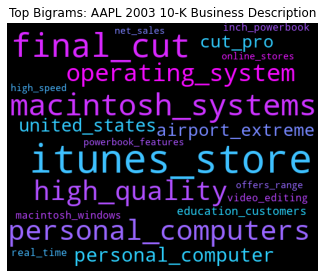

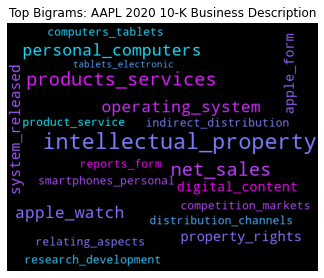

In [3]:
for num, (year, words) in enumerate(top_words.items()):
    wc = WordCloud(height=400, width=500,  colormap='cool')
    fig, ax = plt.subplots(1, 1, num=num+1, clear=True, figsize=(5,4))
    ax.imshow(wc.generate_from_frequencies(words))
    ax.axis("off")
    plt.tight_layout(pad=2)
    ax.set_title(f"Top Bigrams: {ticker} {year} 10-K Business Description")
    #plt.savefig(os.path.join(imgdir, f"{ticker}{year}.jpg"))
plt.show()

# Community Detection with Business Descriptions

In [4]:
# Load spacy vocab
lang = 'en_core_web_lg'
nlp = spacy.load(lang, disable=['ner'])
n_vocab, vocab_dim = nlp.vocab.vectors.shape
print('Language:', lang, '   vocab:', n_vocab, '   dim:', vocab_dim)
stopwords = {'company', 'companys', 'companies', 'product', 'products',
             'service', 'services', 'business', 'description', 'year', 'years'}

# Load stock universes
univs = {y: crsp.get_universe(bd.endmo(int(f"{y-1}1231"))).assign(year=y)
         for y in range(1993, 2021)}

Language: en_core_web_lg    vocab: 684830    dim: 300


## Extract lemmatized nouns from bus10K documents


In [ ]:
A = ed.open(form=form, item=item)  # open bus10K archive
A['year'] = [d.year-(d.month<4) for d in int2date(A['date'])] # set fiscal year

tic = time.time()
for year in [2018, 2017]: #[2020, 2019, 2018, 2017]:
    docs = dict()
    for i, permno in tqdm(enumerate(sorted(univs[year].index))):
        doc = A[A['permno'].eq(permno) & A['year'].eq(year)].sort_values('date')
        if len(doc):
            text = ed[doc.iloc[0]['pathname']].encode('ascii', 'ignore').lower()
            tokens = nlp(text.decode()[:900000])
            nouns = [t.lemma_ for t in tokens if t.pos_ in ['NOUN','PROPN'] and
                     len(t.text)>1 and not (t.is_oov or t.is_stop) and
                     t.text not in stopwords]
            counts = Series(nouns, dtype='object').value_counts()
            if len(counts):
                docs[permno] = counts.to_dict()
    print(year, len(docs), f"{time.time()-tic:.1f}")
    with gzip.open(os.path.join(imgdir, f"docs{year}.json.gz"), 'wt') as f:
        json.dump(docs, f)     # save this year's docs


## Text Vectorizer

In [6]:
from sklearn.feature_extraction import text
max_df, min_df, max_features = 0.5, 25, 10000
#max_df, min_df, max_features = 1.0, 1, None
tv = text.TfidfVectorizer(max_df=max_df,min_df=min_df,max_features=max_features)
cv = text.CountVectorizer(max_df=max_df,min_df=min_df,max_features=max_features)

# Helper to return an iterable of str from dict of docs dicts
def iterable(docs, unique=True, key=False, lemma=False):
    for k, doc in docs.items():
        value = " ".join([k if unique else " ".join([k] * v)
                          for k,v in doc.items()])
        if lemma:
            value = " ".join(t.lemma_ for t in nlp(value))
        yield (k, value) if key else value

## Compute document term frequencies and average word vectors, and cos similiary


In [7]:
cos_tfidf = {}
cos_vector = {}
graphlasso_tfidf = {}
corr_tfidf = {}
for year in [2020]:#, 2019, 2018]:
    with gzip.open(os.path.join(imgdir, f"docs{year}.json.gz"), 'rt') as f:
        docs = json.load(f)

    # document term frequencies and average word vectors
    tic = time.time()
    x = cv.fit_transform(iterable(docs, unique=True)) # term dummy
    feature_names = cv.get_feature_names()
    df = Series({k: v for k,v in zip(feature_names,
                                     np.asarray(np.sum(x, axis=0)).flatten())})
    tfidf = tv.fit_transform(iterable(docs, unique=False)) # tfidf
    vector = np.zeros((len(docs), vocab_dim))
    permnos = []
    for i, (key, doc) in tqdm(enumerate(iterable(docs, unique=False, key=True))):
        permnos.append(int(key))
        vector[i] = nlp(doc).vector
    print(time.time() - tic)

    # compute cosine similarity matrixes between documents
    cos_tfidf[year] = cosine_similarity(tfidf, tfidf)
    #cos_vector[year] = cosine_similarity(vector, vector) 
    #corr_tfidf[year] = np.corrcoef(tfidf.toarray(), rowvar=True)


3219it [26:23,  2.03it/s]


1593.793485879898


## Populate new DataFrame, indexed by permnos, with sic and naics codes


In [8]:
pstat = PSTAT(sql, bd)
vs = DataFrame(index=permnos)
for code in ['sic', 'naics']:
    lookup = pstat.build_lookup('lpermno', code, fillna=0)
    vs[code] = lookup(vs.index)
naics = Sectoring(sql, 'naics', fillna=0)   # supplement from crosswalk
sic = Sectoring(sql, 'sic', fillna=0)
vs['naics'] = vs['naics'].where(vs['naics'] > 0, naics[vs['sic']])
vs['sic'] = vs['sic'].where(vs['sic'] > 0, naics[vs['naics']])
Series(np.sum(vs > 0, axis=0)).rename('Non-missing').to_frame().T

,sic,naics
Non-missing,3219,3219


## Use sectoring scheme

In [9]:
scheme = 'codes49'
codes = {scheme: Sectoring(sql, scheme, fillna=0)}
vs[scheme] = codes[scheme][vs['sic']]
vs = vs[vs[scheme].ne(codes[scheme].fillna)]
vs

,sic,naics,codes49
10026,2050,311812,Food
10028,5990,453998,Rtail
10032,3672,334412,Chips
10044,2060,311352,Food
10051,8093,621498,Hlth
...,...,...,...
93422,1311,2111,Oil
93423,7996,713110,Fun
93426,3674,334413,Chips
93434,100,111998,Agric


## Create edges, and edge value thresholds

In [13]:
perms = [str(p) for p in permnos]
E = DataFrame(data=cos_tfidf[year], index=perms, columns=perms)
E = E.stack()
thresh = [10, 20, 25, 30, 40, 50, 55, 60, 65, 70, 75,  80, 85, 90, 95]
thresh = {t: v for t,v in zip(thresh, np.percentile(E, thresh))}
E = E.reset_index()

## Run community detection on edges 


Min threshold for edges set at 40 %-tile cosine similarity...
Deleting 15 vertex IDs with degree 0.

     vertices    edges   density simple directed weak-components largest-weak
2020     3204  3106986  0.605508   True    False               1         3204
                     modularity  components
cos_sim threshold %                        
40                     0.093159           4
  Community 1: Drugs(465), Softw(156), MedEq(126)
  Community 2: Oil(97), Util(75), Mach(71)
  Community 3: Banks(378), Insur(83), Fin(63)
  Community 4: Rtail(95), Softw(71), Meals(37)

Min threshold for edges set at 60 %-tile cosine similarity...
Deleting 15 vertex IDs with degree 0.

     vertices    edges   density simple directed weak-components largest-weak
2020     3204  2070790  0.403568   True    False               1         3204
                     modularity  components
cos_sim threshold %                        
60                     0.174424           4
  Community 1: Oil(97), Mach(78), 

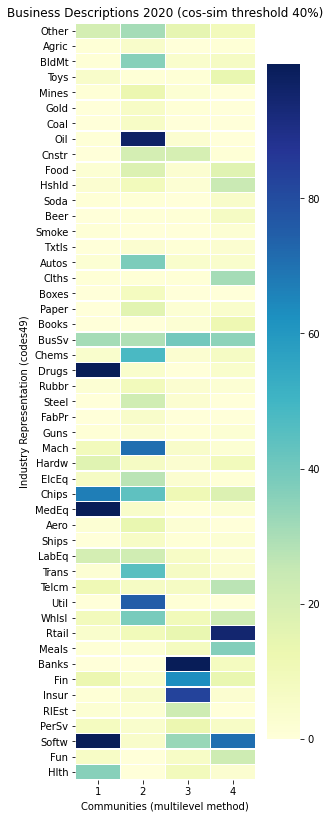

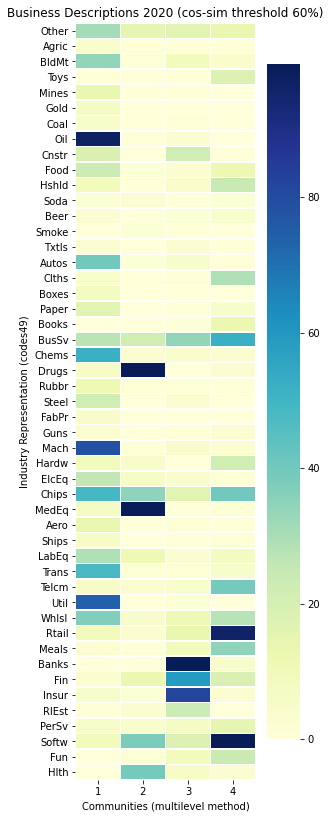

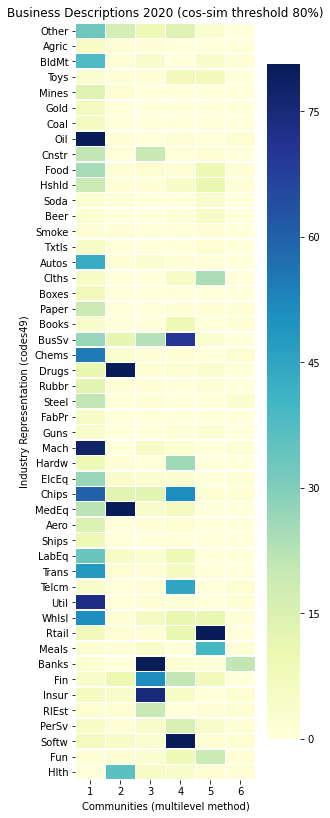

In [17]:
for i, pct in enumerate([40, 60, 80]):  # percentile thresholds to cull edges

    print(f'\nMin threshold for edges set at {pct} %-tile cosine similarity...')
    edges = E[(E.iloc[:,0] != E.iloc[:,1]) & (E.iloc[:,-1] > thresh[pct])]
    attributes = edges.iloc[:, -1].values
    edges = edges.iloc[:, :-1].values

    # Populate igraph including attributes (note: vertex names must be str)
    g = Graph(directed=False)
    g.add_vertices(vs.index.astype(str).to_list(), vs.to_dict(orient='list'))
    g.add_edges(edges, {'score': attributes})
    degree = Series(g.vs.degree())   # to remove zero degree vertexes
    print('Deleting', len(degree[degree==0]), 'vertex IDs with degree 0.\n')
    g.delete_vertices(degree[degree==0].index.to_list())
    g = g.simplify()         # remove self-loops and multi-edges
    s = Series(igraph_info(g, fast=True)).rename(year)
    print(s.to_frame().T)

    # detect communities and report modularity
    c = g.community_multilevel()
    print(DataFrame({'modularity': c.modularity, 'components': len(c.sizes())},
                    index=[pct]).rename_axis('cos_sim threshold %'))

    # plot and display industry representation of communities detected
    detect = 'multilevel'
    indus = pd.concat([Series(c.subgraph(j).vs[scheme]).value_counts().rename(i+1)
                       for i, j in enumerate(np.argsort(c.sizes())[::-1])],
                      axis=1).dropna(axis=0, how='all').fillna(0).astype(int)\
              .reindex(codes[scheme].sectors['name']\
                       .drop_duplicates(keep='first'))
    for j in indus.columns:
        tops = ", ".join(f"{k}({v})" for k,v in
                         indus.sort_values(j)[-1:-4:-1][j].items())
        print(f"  Community {j}:", tops)              
    fig, ax = plt.subplots(num=1+i, clear=True, figsize=(5,12))
    sns.heatmap(indus, square=False, linewidth=.5, ax=ax, yticklabels=1,
                cmap="YlGnBu", robust=True)
    ax.set_yticklabels(indus.index, size=10)
    ax.set_xlabel(f'Communities ({detect} method)')
    ax.set_ylabel(f'Industry Representation ({scheme})')
    ax.set_title(f"Business Descriptions {year} (cos-sim threshold {pct}%)")
    fig.subplots_adjust(left=0.4)
    plt.tight_layout(pad=3)
    plt.savefig(os.path.join(imgdir, f'bus{year}_{pct}.jpg'))
plt.show()